# **BMI Prediction From Human Photograph**
---




In [1]:
!git clone https://github.com/atoms18/BMI-prediction-from-Human-Photograph.git

Cloning into 'BMI-prediction-from-Human-Photograph'...
remote: Enumerating objects: 4438, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 4438 (delta 16), reused 25 (delta 5), pack-reused 4396
Receiving objects: 100% (4438/4438), 342.69 MiB | 34.17 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Updating files: 100% (4232/4232), done.


In [2]:
!pip install ninja
!git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing
%cd /kaggle/working/Self-Correction-Human-Parsing
!mkdir checkpoints
!mkdir inputs
!mkdir outputs
%cd /kaggle/working/

Cloning into 'Self-Correction-Human-Parsing'...
remote: Enumerating objects: 719, done.
remote: Counting objects: 100% (719/719), done.
remote: Compressing objects: 100% (568/568), done.
remote: Total 719 (delta 149), reused 610 (delta 140), pack-reused 0
Receiving objects: 100% (719/719), 3.88 MiB | 10.34 MiB/s, done.
Resolving deltas: 100% (149/149), done.
/kaggle/working/Self-Correction-Human-Parsing
[Errno 2] No such file or directory: '/content'
/kaggle/working/Self-Correction-Human-Parsing


In [5]:
!pip install livelossplot

In [7]:
!pip install gdown

In [8]:

import cv2
import time
import gdown
import numpy
import pandas

from pathlib import Path
from keras import backend as K
from livelossplot import PlotLossesKeras
from sklearn.model_selection import KFold

import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing import image

import matplotlib.pyplot as plt
%matplotlib inline

input_shape = (224, 224, 3)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1.Gathering Data

Datasets contains total of 2,272 images but consider as outlier 444 images so there is 1,828 images available for training and testing.

Sources:
*   Half of the data collectd from *The Photographic Height-Weight Chart* (www.height-weight-chart.com/heightweight.html) via python script.
*   Other half is celebrity body image download via python sctipt by recognites celebrity's name from their face which get from a paper "*Show me your face and I will tell you your height, weight and body mass index*" (https://hal.inria.fr/hal-01799574/document) and use their name to download their body image from Google Images.
*   A small data from *Face-to-height-weight-BMI-estimation* by abhaymise. (https://github.com/abhaymise/Face-to-height-weight-BMI-estimation-)

A data we have got is measured in Imperial system so we use:
\begin{equation}
BMI = \frac{Pound * 703}{(Foot * 12 + Inch)^2}
\end{equation}
To produce a BMI of each images.

/content/BMI-prediction-from-Human-Photograph

Total of datasets: 2272

Mean of BMI: 26.58938050842102

standard Deviation of BMI: 6.666706916267456


<ipython-input-134-541d34fcc185>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  df = hwcd_df.append(celeb_df, ignore_index=True)


,image_filename,weight,foot,inch,bmi
0,410-090-0.png,90,4,10,18.807967
1,410-090-1.png,90,4,10,18.807967
2,410-090-2.png,90,4,10,18.807967
3,410-090-3.png,90,4,10,18.807967
4,410-090-4.png,90,4,10,18.807967
...,...,...,...,...,...
2267,colinfarrell1.jpg,176,5,10,25.250612
2268,colinfarrell2.jpg,176,5,10,25.250612
2269,colinfarrell3.jpg,176,5,10,25.250612
2270,colinfarrell4.jpg,176,5,10,25.250612


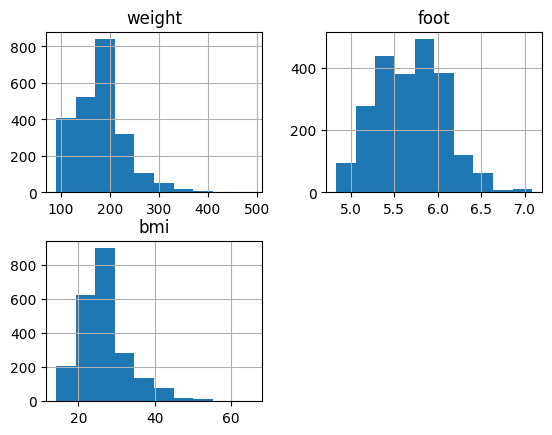

In [ ]:


%cd /content/BMI-prediction-from-Human-Photograph

hwcd_df = pandas.read_csv("height-weight-chart_dataset.csv")
celeb_df = pandas.read_csv("celeb_datasets.csv")

df = hwcd_df.append(celeb_df, ignore_index=True)
bmi = df["weight"] * 703 / (df["foot"] * 12 + df["inch"]) ** 2

foot = df["foot"] + df["inch"] / 12
df_display = df.drop(columns=["foot", "inch"])
df_display = df_display.assign(foot=foot, bmi=bmi)
df_display.hist()
print(f"Total of datasets: {len(bmi.index)}")
print(f"Mean of BMI: {bmi.mean()}")
print(f"standard Deviation of BMI: {bmi.std()}")

df.assign(bmi=bmi)



/kaggle/working/BMI-prediction-from-Human-Photograph
Total of datasets: 5269
Mean of BMI: 26.44634602300921
standard Deviation of BMI: 12.061359886957536


,image_filename,weight,foot,inch,bmi
0,410-090-0.png,90.000000,4.000000,10,18.807967
1,410-090-1.png,90.000000,4.000000,10,18.807967
2,410-090-2.png,90.000000,4.000000,10,18.807967
3,410-090-3.png,90.000000,4.000000,10,18.807967
4,410-090-4.png,90.000000,4.000000,10,18.807967
...,...,...,...,...,...
5264,197_00030.png,55.199147,3.083333,5,21.998299
5265,29_00210.png,115.113798,4.875000,5,20.069440
5266,43_00150.png,144.146515,4.958333,5,24.357911
5267,539_00120.png,6.426031,0.541667,5,34.158790


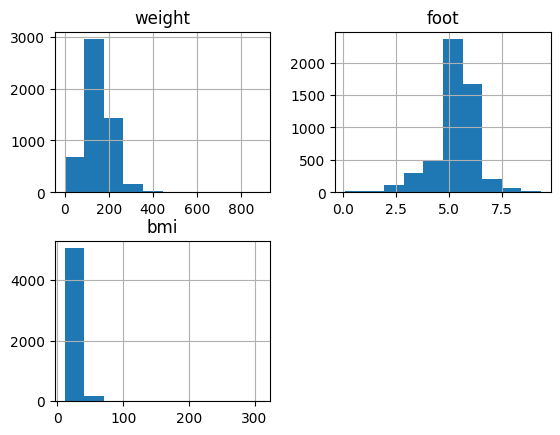

In [60]:


%cd /kaggle/working/BMI-prediction-from-Human-Photograph

data_train_df = pandas.read_csv('/kaggle/working/data_train.csv')
hwcd_df = pandas.read_csv("height-weight-chart_dataset.csv")
celeb_df = pandas.read_csv("celeb_datasets.csv")
df = hwcd_df._append(celeb_df, ignore_index=True)
df = df._append(data_train_df, ignore_index=True)
bmi = df["weight"] * 703 / (df["foot"] * 12 + df["inch"]) ** 2
# print('bmi:', bmi[bmi > 40])
# print('df_display:', df_display.iloc[209,:])

foot = df["foot"] + df["inch"] / 12
df_display = df.drop(columns=["foot", "inch"])
df_display = df_display.assign(foot=foot, bmi=bmi)
df_display.hist()
print(f"Total of datasets: {len(bmi.index)}")
print(f"Mean of BMI: {bmi.mean()}")
print(f"standard Deviation of BMI: {bmi.std()}")

df.assign(bmi=bmi)



## 2.Preparing the data

We are preparing the data by using *Self Correction for Human Parsing* (https://github.com/PeikeLi/Self-Correction-Human-Parsing) by only extract a human body from raw dataset which the result of this model has shown below.
<table>
  <tr>
    <td>
      Original Image:<br>
      <img src="https://drive.google.com/uc?export=view&id=11oqtX5cPf5xCU2IvYBLVFs5sqnMlfm5T" width="200">
    </td>
    <td>
      Preprocessed Image using a model:<br>
      <img src="https://drive.google.com/uc?export=view&id=1ydyIAvFcoIlAxyUago_ZkJuyfSXjEooC" width="200">
    </td>
  </tr>
</table>

And we use a preprocessed image as a filter to get rid of the background by convert all of its colors pixel to 1 and multiply them to original image.

<table>
  <tr>
    <td>
      Filter Image:<br>
      <img src="https://drive.google.com/uc?export=view&id=18rjY14s3a_i9tYWXGR-FOLu0PJ2LpkvG" width="200">
    </td>
    <td>
      Labeled Image:<br>
      <img src="https://drive.google.com/uc?export=view&id=1Bqf6gtkBdL8xhsP8hEXcMDeHMVyiu_k4" width="200" height="273">
    </td>
  </tr>
</table>

Then we resize a labeled image to 244 x 244 x 3 to suit the Resnet152 recommend input tensor.


In [ ]:
import time

# def rgb2gray(rgb):
#     return numpy.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

def preprocess_df(x, y):
  x = x.reset_index()
  X = []
  Y = []
  for i in range(x.shape[0]):

    image_filename = Path(x['image_filename'][i]).stem

    raw_filepath = 'raw_datasets/' + image_filename + ".jpg"
    preprocessed_filepath = 'raw_datasets_preprocessed/' + image_filename + ".png"
    if not Path(raw_filepath).is_file():
      raw_filepath = 'celeb_datasets/' + image_filename + ".jpg"
      preprocessed_filepath = 'celeb_datasets_preprocessed/' + image_filename + ".png"

    if Path(raw_filepath).is_file() and Path(preprocessed_filepath).is_file():
      raw_img = image.load_img(raw_filepath, target_size=(600, 400))
      raw_img = image.img_to_array(raw_img)
      preprocessed_img = image.load_img(preprocessed_filepath, target_size=(600, 400))
      preprocessed_img = image.img_to_array(preprocessed_img)

      preprocessed_img[preprocessed_img[:,:,0] > 0] = 1
      preprocessed_img[preprocessed_img[:,:,1] > 0] = 1
      preprocessed_img[preprocessed_img[:,:,2] > 0] = 1
      # img[numpy.all(img == (128, 128, 128), axis=-1)] = (0, 0, 128) # replace gray with blue
      # img[numpy.all(img == (0, 64, 0), axis=-1)] = (0, 0, 0) # replace green with black
      # img[numpy.all(img == (128, 0, 128), axis=-1)] = (0, 128, 128) # replace purple with cyan
      # img = rgb2gray(img).reshape(input_shape)

      # plt.imshow((raw_img * preprocessed_img).astype(int))
      # break
      img_tmp = raw_img * preprocessed_img

      a1, a2 = img_tmp.shape[:2]
      # print("Raw shape: " + str(img_tmp.shape[:2]))
      biga = max(a1, a2)
      reshape_image = resizeAndPad(img_tmp, (biga, biga), 255)
      # print("shape:", reshape_image.shape[:2])
      reshape_image = cv2.resize(reshape_image, (input_shape[0], input_shape[1]))

      X.append(reshape_image)
      Y.append(y.iloc[i])
      # print("shape2:", reshape_image.shape[:2])

  X = numpy.array(X)
  Y = numpy.array(Y)
  return [X, Y]

start = time.perf_counter()
X, Y = preprocess_df(df, bmi)
print(X, Y)
end = time.perf_counter()
print(f"{end - start:.2f} seconds process time")

[[[[255. 255. 255.]

   [255. 255. 255.]

   [255. 255. 255.]

   ...

   [255. 255. 255.]

   [255. 255. 255.]

   [255. 255. 255.]]



  [[255. 255. 255.]

   [255. 255. 255.]

   [255. 255. 255.]

   ...

   [255. 255. 255.]

   [255. 255. 255.]

   [255. 255. 255.]]



  [[255. 255. 255.]

   [255. 255. 255.]

   [255. 255. 255.]

   ...

   [255. 255. 255.]

   [255. 255. 255.]

   [255. 255. 255.]]



  ...



  [[255. 255. 255.]

   [255. 255. 255.]

   [255. 255. 255.]

   ...

   [255. 255. 255.]

   [255. 255. 255.]

   [255. 255. 255.]]



  [[255. 255. 255.]

   [255. 255. 255.]

   [255. 255. 255.]

   ...

   [255. 255. 255.]

   [255. 255. 255.]

   [255. 255. 255.]]



  [[255. 255. 255.]

   [255. 255. 255.]

   [255. 255. 255.]

   ...

   [255. 255. 255.]

   [255. 255. 255.]

   [255. 255. 255.]]]





 [[[255. 255. 255.]

   [255. 255. 255.]

   [255. 255. 255.]

   ...

   [255. 255. 255.]

   [255. 255. 255.]

   [255. 255. 255.]]



  [[255. 255. 255.]

   [255.

In [62]:
import time
# def rgb2gray(rgb):
#     return numpy.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

def preprocess_df(x, y):
  empty_img = 0
  x = x.reset_index()
  X = []
  Y = []
  for i in range(x.shape[0]):

    image_filename = Path(x['image_filename'][i]).stem

    raw_filepath = '/kaggle/working/inputs/train/' + image_filename + ".png"
    preprocessed_filepath = '/kaggle/working/outputs/train/' + image_filename + ".png"
    if not Path(raw_filepath).is_file():
      raw_filepath = '/kaggle/working/BMI-prediction-from-Human-Photograph/celeb_datasets/' + image_filename + ".jpg"
      preprocessed_filepath = '/kaggle/working/BMI-prediction-from-Human-Photograph/celeb_datasets_preprocessed/' + image_filename + ".png"
      if not Path(raw_filepath).is_file():
        raw_filepath = '/kaggle/working/BMI-prediction-from-Human-Photograph/raw_datasets/' + image_filename + ".jpg"
        preprocessed_filepath = '/kaggle/working/BMI-prediction-from-Human-Photograph/raw_datasets_preprocessed/' + image_filename + ".png"
        if not Path(raw_filepath).is_file():
          empty_img += 1
          print("not Path(raw_filepath).is_file()", raw_filepath)

    if Path(raw_filepath).is_file() and Path(preprocessed_filepath).is_file():
      raw_img = image.load_img(raw_filepath, target_size=(600, 400))
      raw_img = image.img_to_array(raw_img)
      preprocessed_img = image.load_img(preprocessed_filepath, target_size=(600, 400))
      preprocessed_img = image.img_to_array(preprocessed_img)

      preprocessed_img[preprocessed_img[:,:,0] > 0] = 1
      preprocessed_img[preprocessed_img[:,:,1] > 0] = 1
      preprocessed_img[preprocessed_img[:,:,2] > 0] = 1
      # img[numpy.all(img == (128, 128, 128), axis=-1)] = (0, 0, 128) # replace gray with blue
      # img[numpy.all(img == (0, 64, 0), axis=-1)] = (0, 0, 0) # replace green with black
      # img[numpy.all(img == (128, 0, 128), axis=-1)] = (0, 128, 128) # replace purple with cyan
      # img = rgb2gray(img).reshape(input_shape)

      # plt.imshow((raw_img * preprocessed_img).astype(int))
      # break
      img_tmp = raw_img * preprocessed_img

      a1, a2 = img_tmp.shape[:2]
      # print("Raw shape: " + str(img_tmp.shape[:2]))
      biga = max(a1, a2)
      reshape_image = resizeAndPad(img_tmp, (biga, biga), 255)
      # print("shape:", reshape_image.shape[:2])
      reshape_image = cv2.resize(reshape_image, (input_shape[0], input_shape[1]))

      X.append(reshape_image)
      Y.append(y.iloc[i])
      # print("shape2:", reshape_image.shape[:2])

  X = numpy.array(X)
  Y = numpy.array(Y)
  return [X, Y, empty_img]


start = time.perf_counter()
X, Y, empty_img = preprocess_df(df, bmi)
print(X, Y)
end = time.perf_counter()

print("Number of imgs are empty:", empty_img)
print(f"{end - start:.2f} seconds process time")

not Path(raw_filepath).is_file() /kaggle/working/BMI-prediction-from-Human-Photograph/raw_datasets/410-170-0.jpg
not Path(raw_filepath).is_file() /kaggle/working/BMI-prediction-from-Human-Photograph/raw_datasets/411-100-1.jpg
not Path(raw_filepath).is_file() /kaggle/working/BMI-prediction-from-Human-Photograph/raw_datasets/411-100-2.jpg
not Path(raw_filepath).is_file() /kaggle/working/BMI-prediction-from-Human-Photograph/raw_datasets/500-140-4.jpg
not Path(raw_filepath).is_file() /kaggle/working/BMI-prediction-from-Human-Photograph/raw_datasets/500-220-1.jpg
not Path(raw_filepath).is_file() /kaggle/working/BMI-prediction-from-Human-Photograph/raw_datasets/501-100-1.jpg
not Path(raw_filepath).is_file() /kaggle/working/BMI-prediction-from-Human-Photograph/raw_datasets/501-110-1.jpg
not Path(raw_filepath).is_file() /kaggle/working/BMI-prediction-from-Human-Photograph/raw_datasets/501-110-10.jpg
not Path(raw_filepath).is_file() /kaggle/working/BMI-prediction-from-Human-Photograph/raw_datas

### Data Normalization and Augmentation

We use ImageDataGenerator to normalize a labeled and to be augmented by rotating, shifting and horizontal flipling.

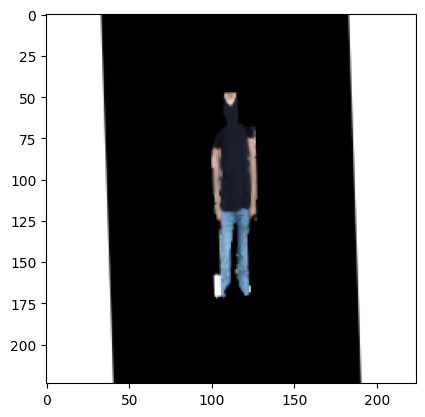

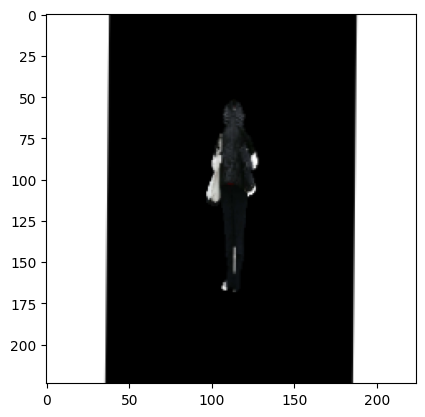

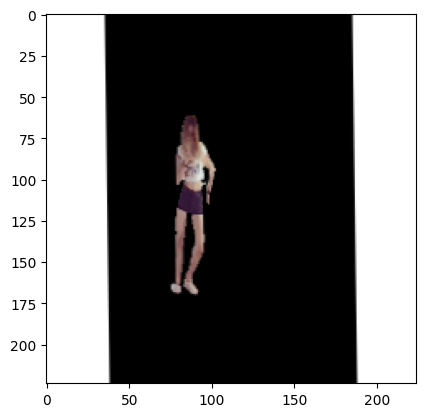

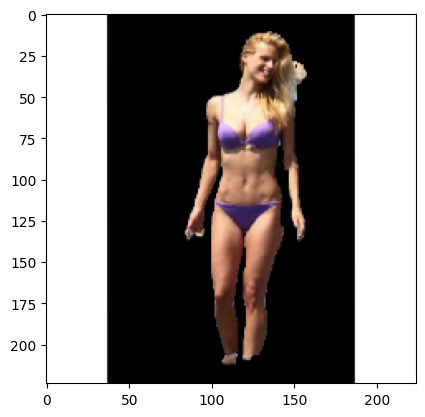

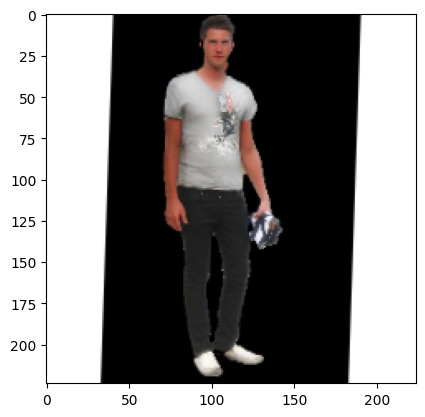

In [63]:

train_datagen = image.ImageDataGenerator(
  samplewise_center=True,
  rotation_range=2,
  width_shift_range=0.02,
  # height_shift_range=0.02,
  # shear_range=0.02,
  # zoom_range=0.02,
  horizontal_flip=True
)
j = 0
for batch in train_datagen.flow(X, batch_size=5):
  for b in batch:
    plt.figure(j)
    plt.imshow(image.array_to_img(b))
    j += 1
  break

test_datagen = image.ImageDataGenerator(
  samplewise_center=True,
)

## 3.Choosing a model

* From the experiments, we decide to use ResNet152 for the best results.
* We use pre-trained weight called "imagenet" to initialize a model.
* By using it, we mean that we use it for extract a feature of human from an image so we freeze an entire model and feed an output to Fully-Connected Layer.
* A Fully-Connected Layer contains 256 neurons and using ReLu function as activation function.
* We use dropout layer with probability 0.25
* An output layer consist of only one neuron which uses linear activation function.


<img src="https://drive.google.com/uc?export=view&id=1u20brFPULhqItLZCa1zrmiHkaNKtqvMX" width="450">

In [68]:
base_model = keras.applications.ResNet152(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling="avg"
)

base_model.trainable = False
base_model.summary()

234698864/234698864 [==============================] - 1s 0us/step
Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                   

### Extract Features

* We use k-fold cross validation to train a model by we choose k=5 and in the meanwhile, we do a features extraction before initialize our own model.
* We keep all 5 fold in the list called train_features, train_labels, test_features and test_labels for not to repeated it.

In [65]:
batch_size=32
def extract_features(x, y, sample_count, datagen):
    features = numpy.zeros(shape=(sample_count, 2048))
    labels = numpy.zeros(shape=(sample_count))
    generator = datagen.flow(
        x, y,
        batch_size=batch_size
    )
    total = 0
    left_index = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        gap = features_batch.shape[0]
        total += gap
        gap_diff = total - sample_count
        gap_diff = gap_diff if gap_diff > 0 else 0
        features[left_index : left_index + (gap-gap_diff)] = features_batch[0:gap-gap_diff]
        labels[left_index : left_index + (gap-gap_diff)] = labels_batch[0:gap-gap_diff]
        left_index += gap
        if total >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features = [None]*5
train_labels = [None]*5
test_features = [None]*5
test_labels = [None]*5

k = 0
kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(X):
  X_train, Y_train, X_test, Y_test = X[train_index], Y[train_index], X[test_index], Y[test_index]

  print(f"Extract features from fold number {k+1}")
  start = time.perf_counter()
  train_features[k], train_labels[k] = extract_features(X_train, Y_train, 2000, datagen=train_datagen)
  test_features[k], test_labels[k] = extract_features(X_test, Y_test, 2000, datagen=test_datagen)
  end = time.perf_counter()
  print(f"Finished with {end - start:.2f} seconds process time")
  k += 1

Extract features from fold number 1
1/1 [==============================] - 0s 40ms/step
Finished with 63.01 seconds process time
Extract features from fold number 2
1/1 [==============================] - 0s 39ms/step
Finished with 55.10 seconds process time
Extract features from fold number 3
1/1 [==============================] - 0s 39ms/step
Finished with 56.38 seconds process time
Extract features from fold number 4
1/1 [==============================] - 0s 39ms/step
Finished with 55.96 seconds process time
Extract features from fold number 5
1/1 [==============================] - 0s 39ms/step
Finished with 58.09 seconds process time


## 4.Training
* Optimizer: The stochastic gradient descent (SGD) algorithm.
* Learning Rate: Start from 1e-5 and then we use the learning rate decay policy, which is implemented as follows:
\begin{equation}
LR = LR_{Base} (1 + \gamma * epoch)^{-power}
\end{equation}
where γ is 0.001 and power is 0.75. We use a momentum of 0.9
* Loss function: Huber function
* Metrics: Huber, Mean Absolute Error and R Squared

In [70]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def lr_scheduler(epoch, lr):
   return 1e-5 * (1 + 0.001 * epoch) ** (-0.75)

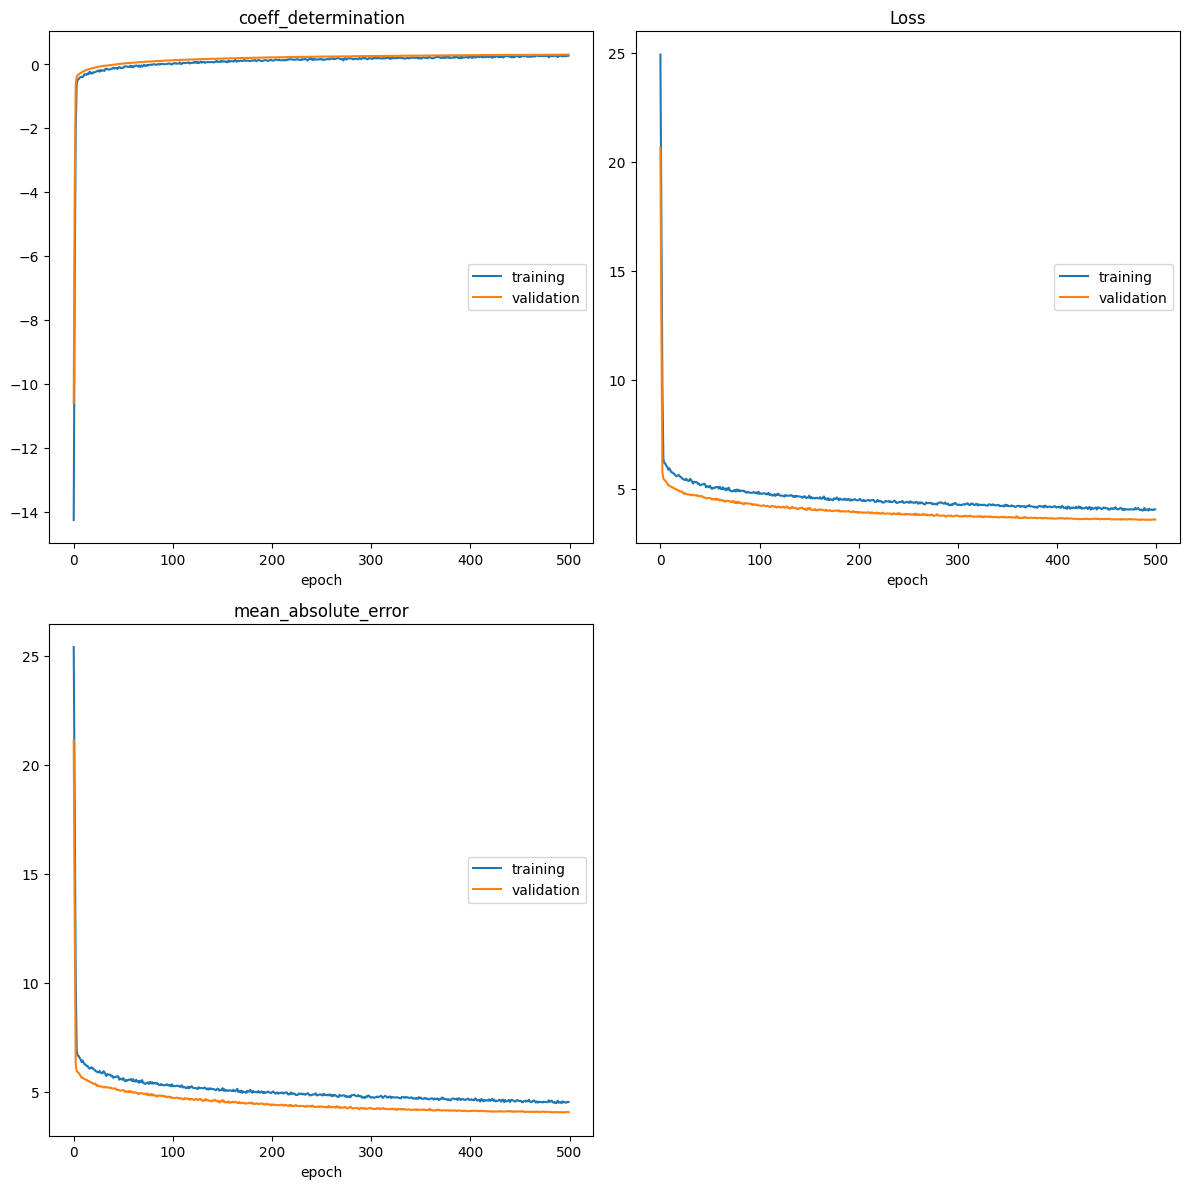

coeff_determination
	training         	 (min:  -14.260, max:    0.275, cur:    0.261)
	validation       	 (min:  -10.594, max:    0.295, cur:    0.295)
Loss
	training         	 (min:    4.003, max:   24.904, cur:    4.057)
	validation       	 (min:    3.573, max:   20.627, cur:    3.588)
mean_absolute_error
	training         	 (min:    4.463, max:   25.404, cur:    4.520)
	validation       	 (min:    4.039, max:   21.127, cur:    4.052)
63/63 - 1s - loss: 4.0570 - mean_absolute_error: 4.5198 - coeff_determination: 0.2607 - val_loss: 3.5878 - val_mean_absolute_error: 4.0522 - val_coeff_determination: 0.2946 - lr: 7.3816e-06 - 1s/epoch - 18ms/step
63/63 [==============================] - 1s 10ms/step - loss: 3.5878 - mean_absolute_error: 4.0522 - coeff_determination: 0.2946


In [67]:




VALIDAITON_LOSS = []

for j in range(5):
  model = Sequential()
  model.add(layers.Dense(256, activation='relu', input_dim=2048))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(1, activation='linear'))

  model.compile(optimizer=keras.optimizers.SGD(
      learning_rate=1e-5,
      momentum=0.9
  ), loss=keras.losses.Huber(), metrics=["mean_absolute_error", coeff_determination])

  history = model.fit(train_features[j], train_labels[j], epochs=500,
    validation_data=(test_features[j], test_labels[j]),
    verbose=2,
    callbacks=[
          PlotLossesKeras(),
          keras.callbacks.LearningRateScheduler(lr_scheduler),
    ]
  )
  model.save(f"last_model0{j}.h5")

  results = model.evaluate(test_features[j], test_labels[j])
  VALIDAITON_LOSS.append(results)

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# axes = plt.gca()
# axes.set_xlim([0, 25])
# plt.show()

# history = model.fit(train_datagen.flow(x_train, y_train, batch_size=16),
#                     epochs=1000,
#                     validation_data=test_datagen.flow(x_test, y_test, batch_size=32),
#                     verbose=2,
#                     callbacks=[
#                           PlotLossesKeras(),
#                           keras.callbacks.LearningRateScheduler(lr_scheduler),
#                           # keras.callbacks.EarlyStopping(
#                           #     monitor='val_loss',
#                           #     patience=5,
#                           #     restore_best_weights=True
#                           # )
#                     ]
# )



## 5.Evaluvate

[Huber loss, MAE, R Squared] of all 5-folds

In [68]:
VALIDAITON_LOSS


[[4.928957462310791, 5.394435882568359, 0.135576069355011],
 [3.6696536540985107, 4.132439136505127, 0.2169470489025116],
 [3.553971290588379, 4.0163960456848145, 0.2663341462612152],
 [4.199212551116943, 4.667779922485352, 0.22160477936267853],
 [3.5877745151519775, 4.052207946777344, 0.2945610582828522]]

## 6.Test with your photo!

We have selected the best model which MAE is equal to 4.053

In [12]:
%cd /kaggle/working/Self-Correction-Human-Parsing
atr_dataset_url = 'https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP'
gdown.download(atr_dataset_url, 'checkpoints/atr.pth', quiet=False)

/kaggle/working/Self-Correction-Human-Parsing


Downloading...
From (uriginal): https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP
From (redirected): https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP&confirm=t&uuid=82002bc7-dc18-4fa0-9f25-aecbc73f4367
To: /kaggle/working/Self-Correction-Human-Parsing/checkpoints/atr.pth
100%|██████████| 267M/267M [00:02<00:00, 127MB/s]  


'checkpoints/atr.pth'

In [9]:
import cv2
import numpy as np

def resizeAndPad(img, size, padColor=0):
    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw:  # shrinking image
        interp = cv2.INTER_AREA
    else:  # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w / h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1:  # horizontal image
        new_w = sw
        new_h = np.round(new_w / aspect).astype(int)
        pad_vert = (sh - new_h) / 2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1:  # vertical image
        new_h = sh
        new_w = np.round(new_h * aspect).astype(int)
        pad_horz = (sw - new_w) / 2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else:  # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor,
                                              (list, tuple, np.ndarray)):  # color image but only one color provided
        padColor = [padColor] * 3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT,
                                    value=padColor)
    # print(h_img.shape[:2])
    return scaled_img

In [ ]:
%cd /content/Self-Correction-Human-Parsing/inputs
from google.colab import files
uploaded = files.upload()

/content/Self-Correction-Human-Parsing/inputs


Saving tam32.png to tam32.png


In [ ]:
print(uploaded)

{'candoi.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\x05\x05\x05\x05\x05\x05\x05\x06\x06\x05\x08\x08\x07\x08\x08\x0b\n\t\t\n\x0b\x11\x0c\r\x0c\r\x0c\x11\x1a\x10\x13\x10\x10\x13\x10\x1a\x17\x1b\x16\x15\x16\x1b\x17) \x1c\x1c )/\'%\'/9339GDG]]}\x01\x05\x05\x05\x05\x05\x05\x05\x06\x06\x05\x08\x08\x07\x08\x08\x0b\n\t\t\n\x0b\x11\x0c\r\x0c\r\x0c\x11\x1a\x10\x13\x10\x10\x13\x10\x1a\x17\x1b\x16\x15\x16\x1b\x17) \x1c\x1c )/\'%\'/9339GDG]]}\xff\xc2\x00\x11\x08\x02\x0b\x00\xcf\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x000\x00\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x04\x03\x02\x01\x06\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x01\x04\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x02\xfd\x90\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x19\xb9\xcd)^9\x16\x12\xb6\xf7\xba\x07l\x00\x00\x00\x00\x00\x00\x0c\xd2ue\x8f8r@\xb1\xde]K\xdc;`\x00\x00\x00\x00\x00\x11\xf8k\

In [ ]:
import os
from PIL import Image

%cd /content/Self-Correction-Human-Parsing

input_filename = Path(next(iter(uploaded))).stem
reshape_image = cv2.imread("inputs/" +  next(iter(uploaded)))
x1, x2 = reshape_image.shape[:2]
print("Raw shape: " + str(reshape_image.shape[:2]))
big = max(x1, x2)
reshape_image = resizeAndPad(reshape_image, (big, big), 255)
path_input = "inputs/" +  next(iter(uploaded))
cv2.imwrite(path_input, reshape_image)
print("Raw shape2: " + str(reshape_image.shape[:2]))

/content/Self-Correction-Human-Parsing

Raw shape: (523, 207)

Raw shape2: (523, 523)


In [ ]:
input_filename = Path(next(iter(uploaded))).stem
test_shape = cv2.imread("inputs/" +  next(iter(uploaded)))
print(next(iter(uploaded)))
print("Raw shape: " + str(test_shape.shape[:2]))

0_F_20_160020_6713168.jpg

Raw shape: (1116, 1116)


/content/Self-Correction-Human-Parsing

Evaluating total class number 18 with ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']

100% 1/1 [00:00<00:00,  2.26it/s]

209 / 209

7641 / 209 ** 2 = 0.2274055081156567


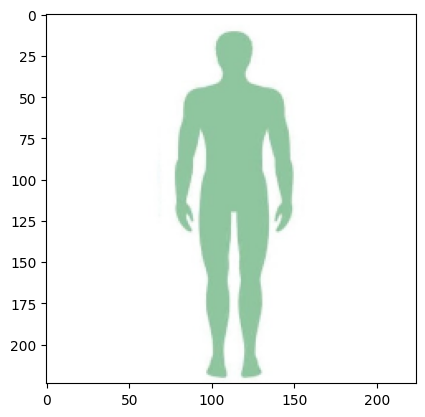

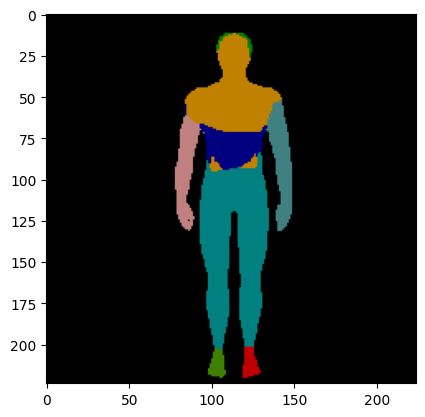

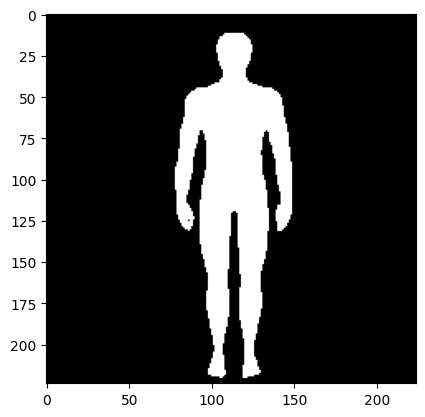

In [ ]:
%cd /content/Self-Correction-Human-Parsing
!python3 simple_extractor.py --dataset 'atr' --model-restore 'checkpoints/atr.pth' --input-dir 'inputs' --output-dir 'outputs'

input_filename = Path(next(iter(uploaded))).stem

raw_input_image = cv2.imread("inputs/" +  next(iter(uploaded)))
raw_input_image = cv2.cvtColor(raw_input_image, cv2.COLOR_BGR2RGB)
# print("Raw shape: " + str(raw_input_image.shape[:2]))
raw_input_image = cv2.resize(raw_input_image, (input_shape[0], input_shape[1]))
# print("Raw shape 2: " + str(raw_input_image.shape[:2]))
plt.figure(0)
plt.imshow(raw_input_image)

preprocessed_input_image = image.load_img("outputs/" +  input_filename + ".png", target_size=input_shape)
preprocessed_input_image = image.img_to_array(preprocessed_input_image)
plt.figure(1)
plt.imshow(preprocessed_input_image.astype(int))

plt.figure(2)
preprocessed_input_image[preprocessed_input_image[:,:,0] > 0] = 1
preprocessed_input_image[preprocessed_input_image[:,:,1] > 0] = 1
preprocessed_input_image[preprocessed_input_image[:,:,2] > 0] = 1
plt.imshow(preprocessed_input_image)
img_bin = preprocessed_input_image
sum_h_large = 0
sum_h_small = 0
sum_h = 0
sum_w = 0
for i in img_bin:
  sum_wh = 0
  for k in i:
    if np.all(k > 0):
      sum_wh += 1
  if sum_wh != 0:
    sum_h_large += 1
    sum_h += 1
    sum_w += sum_wh
  else:
    sum_h_small = max(sum_h_large, sum_h_small)
    sum_h_large = 0
  # print(sum_wh)
max_h = max(sum_h_large, sum_h_small)
print(max_h, "/", sum_h)
print(sum_w, "/", max_h, "** 2 =", sum_w * 1.3 / max_h ** 2)

# print("Số lượng pixel lớn hơn ngưỡng 0:", count/3)




# plt.figure(3)
# final_input_image = raw_input_image * preprocessed_input_image
# plt.imshow(final_input_image.astype(int))


In [ ]:

test_datagen = image.ImageDataGenerator(
  samplewise_center=True,
)

generator = test_datagen.flow(
    numpy.expand_dims(final_input_image, axis=0),
    batch_size=1
)
features_batch = base_model.predict(generator)

dependencies = {
    'coeff_determination': coeff_determination
}
model = keras.models.load_model('/content/Self-Correction-Human-Parsing/last_model00.h5', custom_objects=dependencies)
preds = model.predict(features_batch)
bmi_pred = preds[0][0]
print(f"BMI: {bmi_pred}")
model2 = keras.models.load_model('/content/Self-Correction-Human-Parsing/last_model01.h5', custom_objects=dependencies)
preds2 = model2.predict(features_batch)
bmi_pred = preds2[0][0]
print(f"BMI: {bmi_pred}")
model3 = keras.models.load_model('/content/Self-Correction-Human-Parsing/last_model02.h5', custom_objects=dependencies)
preds3 = model3.predict(features_batch)
bmi_pred = preds3[0][0]
print(f"BMI: {bmi_pred}")
model4 = keras.models.load_model('/content/Self-Correction-Human-Parsing/last_model03.h5', custom_objects=dependencies)
preds4 = model4.predict(features_batch)
bmi_pred = preds4[0][0]
print(f"BMI: {bmi_pred}")
model5 = keras.models.load_model('/content/Self-Correction-Human-Parsing/last_model04.h5', custom_objects=dependencies)
preds5 = model5.predict(features_batch)
bmi_pred = preds5[0][0]
print(f"BMI: {bmi_pred}")
# model6 = keras.models.load_model('/content/BMI-prediction-from-Human-Photograph/4.396_model.h5', custom_objects=dependencies)
# preds6 = model6.predict(features_batch)
# bmi_pred = preds6[0][0]
# print(f"BMI: {bmi_pred}")
# model7 = keras.models.load_model('/content/BMI-prediction-from-Human-Photograph/4.471_model.h5', custom_objects=dependencies)
# preds7 = model7.predict(features_batch)
# bmi_pred = preds7[0][0]
# print(f"BMI: {bmi_pred}")

if bmi_pred < 15:
  print("Very severely underweight")
elif 15 <= bmi_pred < 16:
  print("Severely underweight")
elif 16 <= bmi_pred < 18.5:
  print("Underweight")
elif 18.5 <= bmi_pred < 25:
  print("Normal")
elif 25 <= bmi_pred < 30:
  print("Overweight")
elif 30 <= bmi_pred < 35:
  print("Moderately obese")
elif 35 <= bmi_pred < 40:
  print("Severely obese")
elif bmi_pred >= 40:
  print("Very severely obese")



1/1 [==============================] - 0s 64ms/step

1/1 [==============================] - 0s 144ms/step

BMI: 13.683472633361816

1/1 [==============================] - 0s 115ms/step

BMI: 12.840753555297852

1/1 [==============================] - 0s 43ms/step

BMI: 16.64224624633789

1/1 [==============================] - 0s 41ms/step

BMI: 16.85500144958496

1/1 [==============================] - 0s 42ms/step

BMI: 16.717618942260742

Underweight


**References**
<p>- Self-Correction for Human Parsing (https://arxiv.org/pdf/1910.09777.pdf)</p>
<p>- Show me your face and I will tell you your height,
weight and body mass index (https://hal.inria.fr/hal-01799574/document)</p>
<p>- Estimation of Body Mass Index from
Photographs using Deep Convolutional Neural
Networks (https://arxiv.org/pdf/1908.11694v1.pdf)</p>


# **Thêm customer datasets cho phần 1.Gathering Data**
**Tải 2 tập data gồm 2615 + 726 = 3341 ảnh, trong đó lấy 3000 ảnh làm train và 341 ảnh làm val**

In [13]:
%cd /kaggle/working/
!gdown --id 1Ysk6Ncef72Sbf8HvLMJE3yhQHkopPiQL

/kaggle/working
/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1Ysk6Ncef72Sbf8HvLMJE3yhQHkopPiQL
From (redirected): https://drive.google.com/uc?id=1Ysk6Ncef72Sbf8HvLMJE3yhQHkopPiQL&confirm=t&uuid=f80a8b4f-8ff4-4271-9be0-be640a685897
To: /kaggle/working/full_body_photo_database.zip
100%|████████████████████████████████████████| 375M/375M [00:05<00:00, 74.1MB/s]


In [14]:
%cd /kaggle/working/
!gdown --id 12H1BLY75GrmrCP4fGk_CNrVPSxUGnS2K

/kaggle/working
/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=12H1BLY75GrmrCP4fGk_CNrVPSxUGnS2K
From (redirected): https://drive.google.com/uc?id=12H1BLY75GrmrCP4fGk_CNrVPSxUGnS2K&confirm=t&uuid=15d97257-cfd0-46b2-bc5e-6de6681d06b7
To: /kaggle/working/full-body-tiktok-dancing-DatasetNinja.tar
100%|██████████████████████████████████████| 1.19G/1.19G [00:14<00:00, 83.7MB/s]


In [15]:
!tar -xvf /kaggle/working/full-body-tiktok-dancing-DatasetNinja.tar

LICENSE.md
README.md
meta.json
ds/ann/164_00030.png.json
ds/ann/15_00240.png.json
ds/ann/550_00090.png.json
ds/ann/607_00030.png.json
ds/ann/429_00030.png.json
ds/ann/752_00150.png.json
ds/ann/52_00360.png.json
ds/ann/681_00180.png.json
ds/ann/316_00330.png.json
ds/ann/489_00270.png.json
ds/ann/509_00210.png.json
ds/ann/440_00090.png.json
ds/ann/90_00150.png.json
ds/ann/37_00090.png.json
ds/ann/166_00420.png.json
ds/ann/529_00120.png.json
ds/ann/479_00390.png.json
ds/ann/296_00030.png.json
ds/ann/208_00030.png.json
ds/ann/393_00180.png.json
ds/ann/677_00330.png.json
ds/ann/416_00060.png.json
ds/ann/178_00030.png.json
ds/ann/235_00150.png.json
ds/ann/163_00150.png.json
ds/ann/137_00240.png.json
ds/ann/711_00210.png.json
ds/ann/46_00150.png.json
ds/ann/248_00270.png.json
ds/ann/453_00390.png.json
ds/ann/9_00090.png.json
ds/ann/616_00450.png.json
ds/ann/206_00090.png.json
ds/ann/214_00240.png.json
ds/ann/337_00150.png.json
ds/ann/457_00030.png.json
ds/ann/108_00210.png.json
ds/ann/226_002

In [16]:
!unzip /kaggle/working/full_body_photo_database.zip

Archive:  /kaggle/working/full_body_photo_database.zip
   creating: full_body_photo_database/
  inflating: __MACOSX/._full_body_photo_database  
  inflating: full_body_photo_database/.DS_Store  
  inflating: __MACOSX/full_body_photo_database/._.DS_Store  
  inflating: full_body_photo_database/codebook.pdf  
  inflating: __MACOSX/full_body_photo_database/._codebook.pdf  
   creating: full_body_photo_database/photos/
  inflating: __MACOSX/full_body_photo_database/._photos  
   creating: full_body_photo_database/rating data/
  inflating: __MACOSX/full_body_photo_database/._rating data  
  inflating: full_body_photo_database/photos/BM29-BM33.png  
  inflating: __MACOSX/full_body_photo_database/photos/._BM29-BM33.png  
  inflating: full_body_photo_database/photos/WF73.png  
  inflating: __MACOSX/full_body_photo_database/photos/._WF73.png  
  inflating: full_body_photo_database/photos/AM207-WM114.png  
  inflating: __MACOSX/full_body_photo_database/photos/._AM207-WM114.png  
  inflating: ful

In [49]:
import os
!mkdir /kaggle/working/inputs
!mkdir /kaggle/working/inputs/train
!mkdir /kaggle/working/inputs/val

files1 = os.listdir('/kaggle/working/full_body_photo_database/photos')
files2 = os.listdir('/kaggle/working/ds/img')
for name1 in files1:
  image1 = cv2.imread('/kaggle/working/full_body_photo_database/photos/' + name1)
  cv2.imwrite('/kaggle/working/inputs/train/' + name1, image1)
for i, name2 in enumerate(files2):
  image2 = cv2.imread('/kaggle/working/ds/img/' + name2)
  if i < 341:
    cv2.imwrite('/kaggle/working/inputs/val/' + name2, image2)
  else:
    cv2.imwrite('/kaggle/working/inputs/train/' + name2, image2)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [17]:
import os
files = os.listdir('/kaggle/input/weight-model/weight_files')
print(len(files))
# for namex in files:
#     imagex = cv2.imread('/kaggle/working/inputs/val/' + namex)
#     cv2.imwrite('/kaggle/working/inputs/train/' + namex, imagex)

18


**Tiến hành tạo dữ liệu cho Gathering data**

In [23]:
import os
from PIL import Image

path_imgs = '/kaggle/working/inputs/train' + '/'
name_imgs = os.listdir(path_imgs)
for name_img in name_imgs:
  path_img = path_imgs + name_img
  print("Path:", path_img)
  imageN = cv2.imread(path_img)
  x1, x2 = imageN.shape[:2]
  print("Raw shape: " + str(imageN.shape[:2]))
  big = max(x1, x2)
  imageN = resizeAndPad(imageN, (big, big), 255)
  cv2.imwrite(path_img, imageN)
  print("Last shape: " + str(imageN.shape[:2]))

Path: /kaggle/working/inputs/train/WF29.png
Raw shape: (1876, 2815)
Last shape: (2815, 2815)
Path: /kaggle/working/inputs/train/BF73.png
Raw shape: (1658, 2487)
Last shape: (2487, 2487)
Path: /kaggle/working/inputs/train/AM238_old-WM4.png
Raw shape: (1835, 2753)
Last shape: (2753, 2753)
Path: /kaggle/working/inputs/train/AM248_old-WM194.png
Raw shape: (534, 800)
Last shape: (800, 800)
Path: /kaggle/working/inputs/train/WM103-BM6.png
Raw shape: (534, 800)
Last shape: (800, 800)
Path: /kaggle/working/inputs/train/WM193-BM9.png
Raw shape: (1651, 2475)
Last shape: (2475, 2475)
Path: /kaggle/working/inputs/train/WF77.png
Raw shape: (534, 800)
Last shape: (800, 800)
Path: /kaggle/working/inputs/train/AM218-WM89.png
Raw shape: (1761, 2641)
Last shape: (2641, 2641)
Path: /kaggle/working/inputs/train/BF19.png
Raw shape: (1650, 2475)
Last shape: (2475, 2475)
Path: /kaggle/working/inputs/train/BM92.png
Raw shape: (534, 800)
Last shape: (800, 800)
Path: /kaggle/working/inputs/train/AF211_old-WF4.p

In [25]:
%mkdir /kaggle/working/outputs
%mkdir /kaggle/working/outputs/train
%mkdir /kaggle/working/outputs/val
%cd /kaggle/working/Self-Correction-Human-Parsing
!python3 simple_extractor.py --dataset 'atr' --model-restore 'checkpoints/atr.pth' --input-dir '/kaggle/working/inputs/train' --output-dir '/kaggle/working/outputs/train'


/kaggle/working/Self-Correction-Human-Parsing
Evaluating total class number 18 with ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']
100%|███████████████████████████████████████| 3000/3000 [28:05<00:00,  1.78it/s]


In [ ]:
import csv

data_csv = [['image_filename', 'weight', 'foot', 'inch']]
cnt = 0

name_preprocessed_images = os.listdir('/kaggle/working/outputs/train')
for name in name_preprocessed_images:
  preprocessed_input_image = image.load_img('/kaggle/working/outputs/train/' + name, target_size=input_shape)
  preprocessed_input_image = image.img_to_array(preprocessed_input_image)
  # plt.figure(0)
  # plt.imshow(preprocessed_input_image.astype(int))

  # plt.figure(1)
  preprocessed_input_image[preprocessed_input_image[:,:,0] > 0] = 1
  preprocessed_input_image[preprocessed_input_image[:,:,1] > 0] = 1
  preprocessed_input_image[preprocessed_input_image[:,:,2] > 0] = 1
  # plt.imshow(preprocessed_input_image)
  img_bin = preprocessed_input_image
  sum_h_large = 0
  sum_h_small = 0
  sum_h = 0
  sum_w = 0
  for i in img_bin:
    sum_wh = 0
    for k in i:
      if np.all(k > 0):
        sum_wh += 1
    if sum_wh != 0:
      sum_h_large += 1
      sum_h += 1
      sum_w += sum_wh
    else:
      sum_h_small = max(sum_h_large, sum_h_small)
      sum_h_large = 0
    # print(sum_wh)
  max_h = max(sum_h_large, sum_h_small)
  # print(name, max_h, "/", sum_h)
  sum_w *= 130
  if max_h == 0:
    print(name, max_h, "/", sum_h)
    continue
  # print(sum_w, "/", max_h, "** 2 =", sum_w / max_h ** 2)
  feet = (max_h - 10) / 12 / 2
  wei = sum_w / 703 / 4
  data_csv.append([name, str(wei), str(feet), '5'])
  print(name, wei, "* 703 / (", feet, "* 12 + 5) ** 2 =", wei * 703 / (feet * 12 + 5) ** 2)
  cnt += 1
  print(cnt, "/ 3000")

with open('/kaggle/working/data_train.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(data_csv)
    print("Write done!")


WF29.png 112.84850640113798 * 703 / ( 4.583333333333333 * 12 + 5) ** 2 = 22.036805555555556
1 / 3000
BF73.png 148.49217638691323 * 703 / ( 5.0 * 12 + 5) ** 2 = 24.70769230769231
2 / 3000
AM238_old-WM4.png 143.96159317211948 * 703 / ( 4.583333333333333 * 12 + 5) ** 2 = 28.1125
3 / 3000
AM248_old-WM194.png 161.06685633001422 * 703 / ( 4.958333333333333 * 12 + 5) ** 2 = 27.217114356108407
4 / 3000
WM103-BM6.png 182.65647226173542 * 703 / ( 5.208333333333333 * 12 + 5) ** 2 = 28.182716049382716
5 / 3000
WM193-BM9.png 174.84352773826458 * 703 / ( 5.041666666666667 * 12 + 5) ** 2 = 28.6498455800944
6 / 3000
WF77.png 144.65504978662872 * 703 / ( 5.041666666666667 * 12 + 5) ** 2 = 23.70316415127323
7 / 3000
AM218-WM89.png 154.82574679943102 * 703 / ( 4.5 * 12 + 5) ** 2 = 31.26759551852916
8 / 3000
BF19.png 149.55547652916073 * 703 / ( 4.833333333333333 * 12 + 5) ** 2 = 26.48966994205089
9 / 3000
BM92.png 153.34637268847794 * 703 / ( 4.958333333333333 * 12 + 5) ** 2 = 25.91250525809747
10 / 3000

In [30]:
with open('/kaggle/working/data_train.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      # if float(row[2]) > 40:
        print(row)

['image_filename', 'weight', 'foot', 'inch']
['WF29.png', '112.84850640113798', '4.583333333333333', '5']
['BF73.png', '148.49217638691323', '5.0', '5']
['AM238_old-WM4.png', '143.96159317211948', '4.583333333333333', '5']
['AM248_old-WM194.png', '161.06685633001422', '4.958333333333333', '5']
['WM103-BM6.png', '182.65647226173542', '5.208333333333333', '5']
['WM193-BM9.png', '174.84352773826458', '5.041666666666667', '5']
['WF77.png', '144.65504978662872', '5.041666666666667', '5']
['AM218-WM89.png', '154.82574679943102', '4.5', '5']
['BF19.png', '149.55547652916073', '4.833333333333333', '5']
['BM92.png', '153.34637268847794', '4.958333333333333', '5']
['AF211_old-WF4.png', '175.62944523470838', '5.125', '5']
['WF35.png', '152.56045519203414', '4.583333333333333', '5']
['AM239-WM175.png', '152.1443812233286', '5.125', '5']
['WM177.png', '161.06685633001422', '5.25', '5']
['WM97.png', '145.8108108108108', '4.541666666666667', '5']
['AM213-WM47.png', '143.22190611664297', '4.5833333333

In [3]:
!zip -r /kaggle/working/input_train.zip /kaggle/working/inputs/train

  adding: kaggle/working/inputs/train/ (stored 0%)
  adding: kaggle/working/inputs/train/147_00030.png (deflated 7%)
  adding: kaggle/working/inputs/train/WM7.png (deflated 8%)
  adding: kaggle/working/inputs/train/137_00300.png (deflated 6%)
  adding: kaggle/working/inputs/train/65_00360.png (deflated 7%)
  adding: kaggle/working/inputs/train/374_00330.png (deflated 10%)
  adding: kaggle/working/inputs/train/422_00270.png (deflated 6%)
  adding: kaggle/working/inputs/train/307_00390.png (deflated 7%)
  adding: kaggle/working/inputs/train/17_00270.png (deflated 9%)
  adding: kaggle/working/inputs/train/591_00270.png (deflated 8%)
  adding: kaggle/working/inputs/train/239_00180.png (deflated 6%)
  adding: kaggle/working/inputs/train/WF89.png (deflated 6%)
  adding: kaggle/working/inputs/train/691_00270.png (deflated 6%)
  adding: kaggle/working/inputs/train/281_00180.png (deflated 8%)
  adding: kaggle/working/inputs/train/BF11-BF14.png (deflated 11%)
  adding: kaggle/working/inputs/trai

# **Evaluate customer datasets**

In [50]:
import os
files = os.listdir('/kaggle/input/outputs/content/outputs/val')
print(len(files))

341


Length: 339


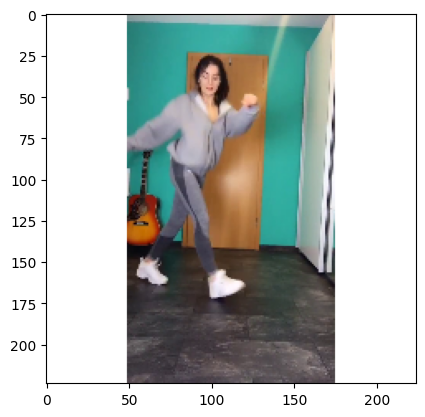

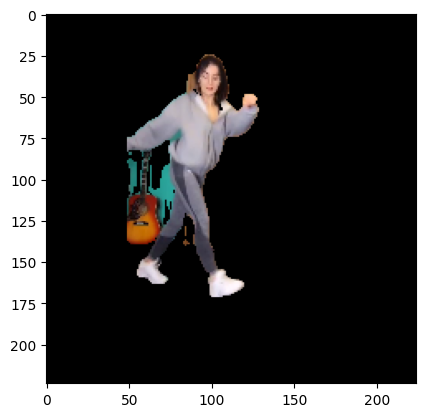

In [65]:
import csv


img_val_list = []
with open('/kaggle/input/csv-files/data_val.csv') as csv_val:
    csv_val = csv.reader(csv_val, delimiter=',')
    for i, row in enumerate(csv_val):
        if i == 0:
            continue
#         print(i, row)
        
        raw_input_image = cv2.imread("/kaggle/working/inputs/train/" + row[0])
#         print("Raw shape: " + str(raw_input_image.shape[:2]))
        if not Path("/kaggle/working/inputs/train/" + row[0]).is_file():
            print("Not file:", "/kaggle/working/inputs/train/" + row[0])
        if not Path("/kaggle/input/csv-files/outputs/content/outputs/val/" + row[0]).is_file():
            print("Not file:", "/kaggle/input/csv-files/outputs/content/outputs/val/" + row[0])
        raw_input_image = cv2.cvtColor(raw_input_image, cv2.COLOR_BGR2RGB)
        raw_input_image = cv2.resize(raw_input_image, (input_shape[0], input_shape[1]))
        plt.figure(0)
        plt.imshow(raw_input_image)
        
        preprocessed_input_image = image.load_img("/kaggle/input/csv-files/outputs/content/outputs/val/" + row[0], target_size=input_shape)
        preprocessed_input_image = image.img_to_array(preprocessed_input_image)

        preprocessed_input_image[preprocessed_input_image[:,:,0] > 0] = 1
        preprocessed_input_image[preprocessed_input_image[:,:,1] > 0] = 1
        preprocessed_input_image[preprocessed_input_image[:,:,2] > 0] = 1

        plt.figure(3)
        final_input_image = raw_input_image * preprocessed_input_image
        plt.imshow(final_input_image.astype(int))
        img_val_list.append(final_input_image)
print('Length:', len(img_val_list))   


In [92]:
accuracy_list = []

for k, model_name in enumerate(os.listdir('/kaggle/input/weight-model/weight_files')):
    mean_accuracy = 0
    for i, final_input_image in enumerate(img_val_list):
        test_datagen = image.ImageDataGenerator(
          samplewise_center=True,
        )

        generator = test_datagen.flow(
            numpy.expand_dims(final_input_image, axis=0),
            batch_size=1
        )
        features_batch = base_model.predict(generator)

        dependencies = {
            'coeff_determination': coeff_determination
        }

        model = keras.models.load_model('/kaggle/input/weight-model/weight_files/' + model_name, custom_objects=dependencies)
        preds = model.predict(features_batch)
        bmi_pred = preds[0][0]
        bmi_real = float(row[1]) * 703 / (float(row[2]) * 12 + float(row[3])) ** 2
        accuracy = abs(bmi_pred - bmi_real) / bmi_real
        mean_accuracy += accuracy
#         print(f"BMI{k+1}: {bmi_pred}", model_path, accuracy)

        print(i+1, "/ 339")
    
    accuracy_list.append([mean_accuracy/339, model_name])
    print('Accuracy:', mean_accuracy/339, model_name)


1/1 [==============================] - 0s 45ms/step
1 / 339
1/1 [==============================] - 0s 45ms/step
2 / 339
1/1 [==============================] - 0s 47ms/step
3 / 339
1/1 [==============================] - 0s 44ms/step
4 / 339
1/1 [==============================] - 0s 46ms/step
5 / 339
1/1 [==============================] - 0s 48ms/step
6 / 339
1/1 [==============================] - 0s 45ms/step
7 / 339
1/1 [==============================] - 0s 46ms/step
8 / 339
1/1 [==============================] - 0s 46ms/step
9 / 339
1/1 [==============================] - 0s 47ms/step
10 / 339
1/1 [==============================] - 0s 45ms/step
11 / 339
1/1 [==============================] - 0s 45ms/step
12 / 339
1/1 [==============================] - 0s 47ms/step
13 / 339
1/1 [==============================] - 0s 47ms/step
14 / 339
1/1 [==============================] - 0s 49ms/step
15 / 339
1/1 [==============================] - 0s 45ms/step
16 / 339
1/1 [============================

In [86]:
with open('/kaggle/input/csv-files/data_val.csv') as csv_val:
    csv_val = csv.reader(csv_val, delimiter=',')
    for i, row in enumerate(csv_val):
        if i == 0:
            continue
        bmi_real = float(row[1]) * 703 / (float(row[2]) * 12 + float(row[3])) ** 2
        print(i, float(row[1]), abs(bmi_real-100))
        print(i, float(row[1]), bmi_real-100)

1 148.26102418207682 78.10806553245116
1 148.26102418207682 -78.10806553245116
2 133.46728307254622 80.00372955405189
2 133.46728307254622 -80.00372955405189
3 260.1849217638691 78.15282630117352
3 260.1849217638691 -78.15282630117352
4 65.78591749644382 74.98783126014061
4 65.78591749644382 -74.98783126014061
5 130.0 79.01974288337925
5 130.0 -79.01974288337925
6 167.58534850640115 83.10265696152605
6 167.58534850640115 -83.10265696152605
7 147.42887624466573 75.46923076923076
7 147.42887624466573 -75.46923076923076
8 95.6045519203414 76.95130315500685
8 95.6045519203414 -76.95130315500685
9 84.78662873399716 79.55932784636488
9 84.78662873399716 -79.55932784636488
10 28.662873399715505 78.33915614082235
10 28.662873399715505 -78.33915614082235
11 97.63869132290185 75.56425774296903
11 97.63869132290185 -75.56425774296903
12 17.197724039829303 52.7734375
12 17.197724039829303 -52.7734375
13 69.16073968705548 79.33042831331703
13 69.16073968705548 -79.33042831331703
14 281.312233285917

In [94]:
for acc in accuracy_list:
    print("Accuracy is", acc[0], "with", acc[1])

Accuracy is 0.5927826334526725 with last_models4.667_500eps.h5
Accuracy is 0.49735956595379266 with last_model4.058_500eps.h5
Accuracy is 0.47345842059095644 with last_model4.398_500eps.h5
Accuracy is 0.5115943017696446 with last_model2_4.001_500eps.h5
Accuracy is 0.5167983695959251 with last_model2_4.324_500eps.h5
Accuracy is 0.511522117360341 with last_model4.732_100eps.h5
Accuracy is 0.5867775814735398 with last_models5.394_500eps.h5
Accuracy is 0.44035021398892144 with last_model4.068_500eps.h5
Accuracy is 0.47548401076428404 with last_model2_3.672_500eps.h5
Accuracy is 0.5105217507847349 with last_model5.042_100eps.h5
Accuracy is 0.47402632071109757 with last_model2_3.468_500eps.h5
Accuracy is 0.5219276069955915 with last_model4.323_500eps.h5
Accuracy is 0.5172489807701233 with last_model5.025_100eps.h5
Accuracy is 0.5790058594521861 with last_models4.132_500eps.h5
Accuracy is 0.5443984291892728 with last_models4.052_500eps.h5
Accuracy is 0.47196685864606736 with last_model2_4.903